# Simulate observations of a single target, try to find transit

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.stats import mad_std, BoxLeastSquares
from batman import TransitModel, TransitParams
from astropy.constants import R_earth, R_sun, M_sun, G
from glob import glob
from scipy.optimize import fmin_l_bfgs_b, fmin_powell
from copy import deepcopy
from scipy.stats import binned_statistic

from toolkit import Observation, LightCurve

In [124]:
# Fractino of nights lost to bad weather
bad_weather = 0.3

# Select number of targets
n_objects = 3

# Months in a semester
n_months = 3

# Clip outliers
sigma_outliers = 5  # sigma

In [125]:
# Transiting planet

M_star = 0.077 * M_sun
R_star = 0.111 * R_sun

params = TransitParams()
params.per = 1.6  # *u.day
params.rp = 1. * float(R_earth/R_star)
params.limb_dark = 'quadratic'
params.u = [1.0, 0.0]  # Luger 2017
params.w = 90
params.ecc = 0
params.a = float(((G*M_star*(params.per*u.day)**2)/(4*np.pi**2))**(1/3) / R_star)
params.inc = 90
params.t0 = np.random.rand()
params.duration = 1/24

In [126]:
times_semester = np.arange(0, (n_months*30*u.day).to(u.min).value, (1.6*u.min).value)  # minutes
midnight = 0
period = (24*u.hour).to(u.min).value

# Roughly account for the day-night cycle
night_times = ((times_semester - midnight) % period)/period
night_times = night_times < 0.5

In [127]:
# Load real light curves
lc_paths = glob('data/npy/*.npy')
real_lcs = [np.load(p) for p in lc_paths]

In [128]:
# Observe each target for 1/n of a night, where n is the number of targets
each_night = np.split(times_semester, np.argwhere(np.abs(np.diff(night_times.astype(int))) > 0.5)[:, 0])

obs = []
for night in each_night: 
    # simulate weather losses
    if np.random.rand() > bad_weather: 
        split_night = np.split(night[len(night)%n_objects:], n_objects)
        random_night = np.random.randint(0, len(real_lcs))
        obs_times = split_night[0]
        obs_fluxes = np.tile(real_lcs[random_night].T, 2).T[:len(obs_times), 1]    
        obs.append(Observation(obs_times, obs_fluxes))

In [129]:
# Concatenate observations
t = []
f = []

for o in obs: 
    t.append(o.times)
    f.append(o.fluxes)
    
all_obs = Observation(np.concatenate(t), np.concatenate(f))

med = np.median(all_obs.fluxes)
std = mad_std(all_obs.fluxes)

# Reject outliers at the 5-sigma level
reject = np.abs(all_obs.fluxes - med) > sigma_outliers * std

all_obs.times = all_obs.times[~reject]
all_obs.fluxes = all_obs.fluxes[~reject]

# Compute transit model 

transit_model = TransitModel(params, (all_obs.times*u.min).to(u.day).value, 
                             supersample_factor=3, 
                             exp_time=(1.6*u.min).to(u.day).value
                             ).light_curve(params)
all_obs.fluxes *= transit_model

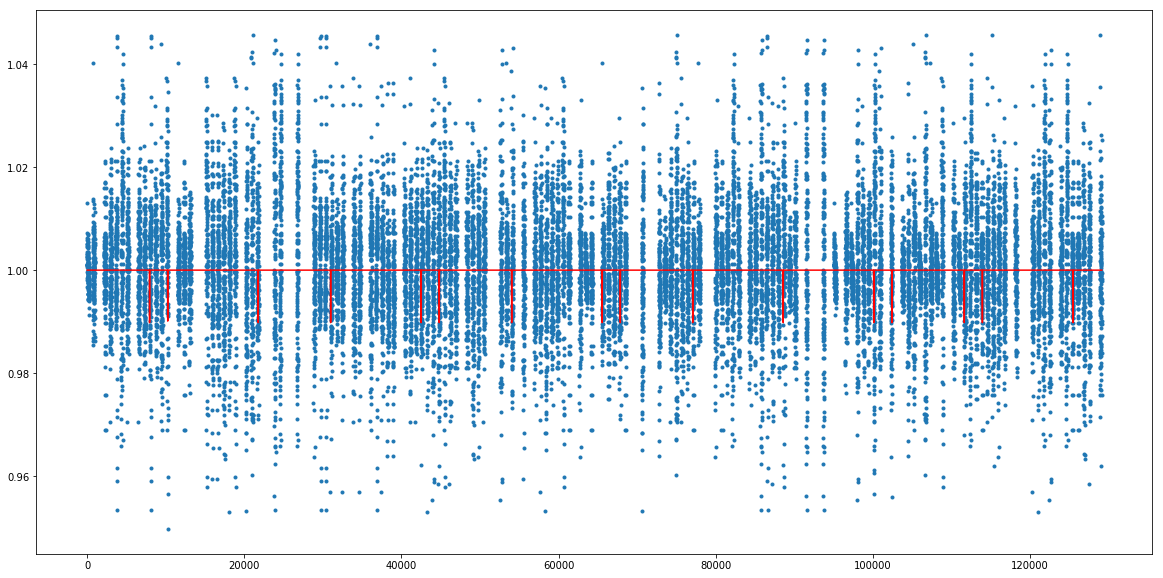

In [130]:
plt.figure(figsize=(20, 10))
plt.plot(all_obs.times, all_obs.fluxes, '.')
plt.plot(all_obs.times, transit_model, 'r')

In [131]:
# Fit the observations with a transit model 

yerr = 0.01

def minimize(p): 
    t0, per = p 
    trial_params = deepcopy(params)
    trial_params.t0 = t0
    trial_params.per = per
    transit_model = TransitModel(trial_params, 
                                 (all_obs.times*u.min).to(u.day).value, 
                                 supersample_factor=3, 
                                 exp_time=(1.6*u.min).to(u.day).value
                                 ).light_curve(trial_params)
    return np.sum((transit_model - all_obs.fluxes)**2/yerr**2)

initp = [params.t0, params.per]

result = fmin_powell(minimize, initp)

Optimization terminated successfully.
         Current function value: 28528.410463
         Iterations: 1
         Function evaluations: 48


In [132]:
# Compare results to correct answer
result, initp

(array([0.71787678, 1.60000092]), [0.7182898468954059, 1.6])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


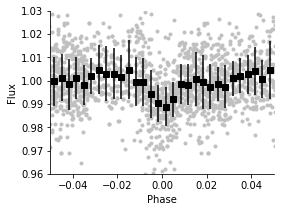

In [133]:
# Plot results
best_t0, best_per = result

phases = (((all_obs.times*u.min).to(u.day).value - best_t0) % best_per) / best_per
phases[phases > 0.5] -= 1

plotrange = [-0.05, 0.05] 

bs = binned_statistic(phases, all_obs.fluxes, bins=30, range=plotrange, statistic='median')

stddev = binned_statistic(phases, all_obs.fluxes, bins=30, range=plotrange, statistic=mad_std)

bincenters = 0.5 * (bs.bin_edges[1:] + bs.bin_edges[:-1])

plt.figure(figsize=(4, 3))
plt.plot(phases, all_obs.fluxes, '.', color='silver')
plt.errorbar(bincenters, bs.statistic, stddev.statistic, color='k', fmt='s', zorder=10)
plt.xlim(plotrange)
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.ylim([0.96, 1.03])
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.savefig('plots/sim_lc.pdf', bbox_inches='tight')

In [134]:
bls = BoxLeastSquares((all_obs.times*u.min).to(u.day).value, all_obs.fluxes)

In [135]:
periods = np.linspace(1, 5, 5000)
duration = 0.4 / 24
bls_results = bls.power(periods, duration)

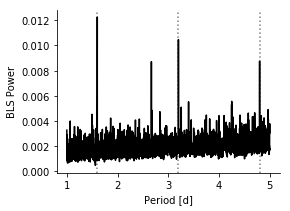

In [136]:
plt.figure(figsize=(4, 3))

for i in range(1, 4): 
    plt.axvline(i*params.per, ls=':', color='gray')

plt.plot(bls_results.period, bls_results.power, 'k')

plt.xlabel('Period [d]')
plt.ylabel('BLS Power')
for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.savefig('plots/sim_bls.pdf', bbox_inches='tight')